In [1]:
import os

from pyment.models import RankingSFCN, RegressionSFCN, SoftClassificationSFCN
from pyment.postprocessing import get_postprocessing


IMAGE_FOLDER = os.path.join(os.path.expanduser('~'), 'data', 'IXI', 'freesurfer+fsl')
LABELS_FILE = os.path.join(os.path.expanduser('~'), 'data', 'IXI', 'IXI.xls')
MODEL = SoftClassificationSFCN
WEIGHTS = 'brain-age-2022'
# Min and max age should match that of the model (e.g. 3-95 for brain-age-2022),
# not that of the dataset
MIN_AGE = 3
MAX_AGE = 95

model = MODEL(weights=WEIGHTS, prediction_range=(MIN_AGE, MAX_AGE))

2024-03-26 20:10:22.456892: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-03-26 20:10:22.456917: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-26 20:10:22.456923: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-26 20:10:22.456942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-26 20:10:22.456955: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
import nibabel as nib
import numpy as np
import pandas as pd

from tqdm import tqdm


labels = pd.read_excel(LABELS_FILE)
predictions = []

for imageid in tqdm(os.listdir(IMAGE_FOLDER)):
    path = os.path.join(IMAGE_FOLDER, imageid, 'mri', 'cropped.nii.gz')
    subjectid = int(imageid[3:6])
    
    if not os.path.isfile(path):
        print(f'Skipping {imageid}: Missing cropped.nii.gz')
        continue
    elif subjectid not in labels['IXI_ID'].values:
        print(f'Skipping {imageid}: Missing labels')
        continue

    age = labels.loc[labels['IXI_ID'] == subjectid, 'AGE'].values[0]
    
    img = nib.load(path)
    img = img.get_fdata()
    
    # Adds an extra dimension to fake the image being part of a batch
    img = np.expand_dims(img, 0)
    
    prediction = model.predict(img, verbose=0)[0]
    prediction = model.postprocess(prediction)
    predictions.append({
        'imageid': imageid,
        'age': age,
        'prediction': prediction
    })

predictions = pd.DataFrame(predictions)

  1%|▊                                                                                                                   | 3/429 [00:06<16:12,  2.28s/it]

Skipping IXI661-HH-2788-T1: Missing labels


 19%|█████████████████████▍                                                                                             | 80/429 [02:58<13:26,  2.31s/it]

Skipping IXI097-HH-1619-T1: Missing cropped.nii.gz


 25%|████████████████████████████▍                                                                                     | 107/429 [03:58<12:22,  2.31s/it]

Skipping IXI362-HH-2051-T1: Missing cropped.nii.gz


 28%|███████████████████████████████▌                                                                                  | 119/429 [04:23<11:41,  2.26s/it]

Skipping IXI517-IOP-1144-T1: Missing cropped.nii.gz


 32%|████████████████████████████████████▏                                                                             | 136/429 [05:00<11:19,  2.32s/it]

Skipping IXI184-Guys-0794-T1: Missing cropped.nii.gz


 32%|████████████████████████████████████▉                                                                             | 139/429 [05:05<09:13,  1.91s/it]

Skipping IXI589-Guys-1080-T1: Missing labels


 37%|█████████████████████████████████████████▉                                                                        | 158/429 [05:47<10:43,  2.37s/it]

Skipping IXI637-HH-2785-T1: Missing labels


 38%|███████████████████████████████████████████▎                                                                      | 163/429 [05:57<09:41,  2.19s/it]

Skipping IXI340-IOP-0915-T1: Missing labels


 44%|██████████████████████████████████████████████████▍                                                               | 190/429 [07:00<09:59,  2.51s/it]

Skipping IXI347-IOP-0927-T1: Missing labels


 48%|███████████████████████████████████████████████████████▎                                                          | 208/429 [07:44<09:53,  2.69s/it]

Skipping IXI457-Guys-0984-T1: Missing labels


 55%|██████████████████████████████████████████████████████████████▉                                                   | 237/429 [08:58<08:17,  2.59s/it]

Skipping IXI593-Guys-1109-T1: Missing cropped.nii.gz


 68%|█████████████████████████████████████████████████████████████████████████████▌                                    | 292/429 [11:15<05:48,  2.55s/it]

Skipping IXI081-Guys-0855-T1: Missing labels


 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 343/429 [13:22<03:36,  2.52s/it]

Skipping IXI345-IOP-0928-T1: Missing labels


 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                     | 349/429 [13:33<02:56,  2.21s/it]

Skipping IXI333-IOP-0926-T1: Missing labels


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████            | 384/429 [14:55<01:52,  2.49s/it]

Skipping IXI638-HH-2786-T1: Missing labels


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████           | 388/429 [15:03<01:30,  2.20s/it]

Skipping IXI387-HH-2101-T1: Missing cropped.nii.gz


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 396/429 [15:19<01:13,  2.23s/it]

Skipping IXI643-HH-2787-T1: Missing labels


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 429/429 [16:33<00:00,  2.32s/it]


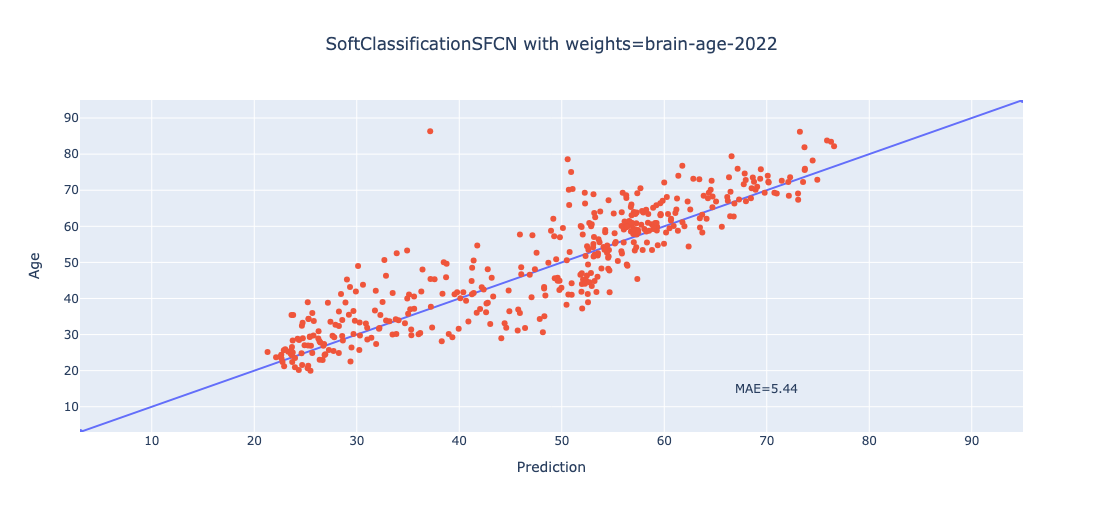

In [4]:
import plotly.graph_objs as go

traces = [
    go.Scatter(
        x=[MIN_AGE, MAX_AGE],
        y=[MIN_AGE, MAX_AGE],
        showlegend=False
    ),
    go.Scatter(
        x=predictions['prediction'],
        y=predictions['age'],
        mode='markers',
        showlegend=False
    )
]

mae = np.mean(np.abs(predictions['prediction'] - predictions['age']))

layout = go.Layout(
    title={'x': 0.5, 'text': f'{model.__class__.__name__} with weights={WEIGHTS}'},
    xaxis={'range': [MIN_AGE, MAX_AGE], 'title': 'Prediction'},
    yaxis={'range': [MIN_AGE, MAX_AGE], 'title': 'Age'},
    width=512,
    height=512,
    annotations=[{'x':70, 'y':15, 'text': f'MAE={mae:.2f}', 'showarrow': False}]
)

figure = go.Figure(traces, layout)
figure.show()